In [6]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import json
from pprint import pprint

from sklearn import preprocessing
from sklearn import svm

PROBLEM = "o_38"
DATADIR = "data/dsBox/" + PROBLEM + "/data"


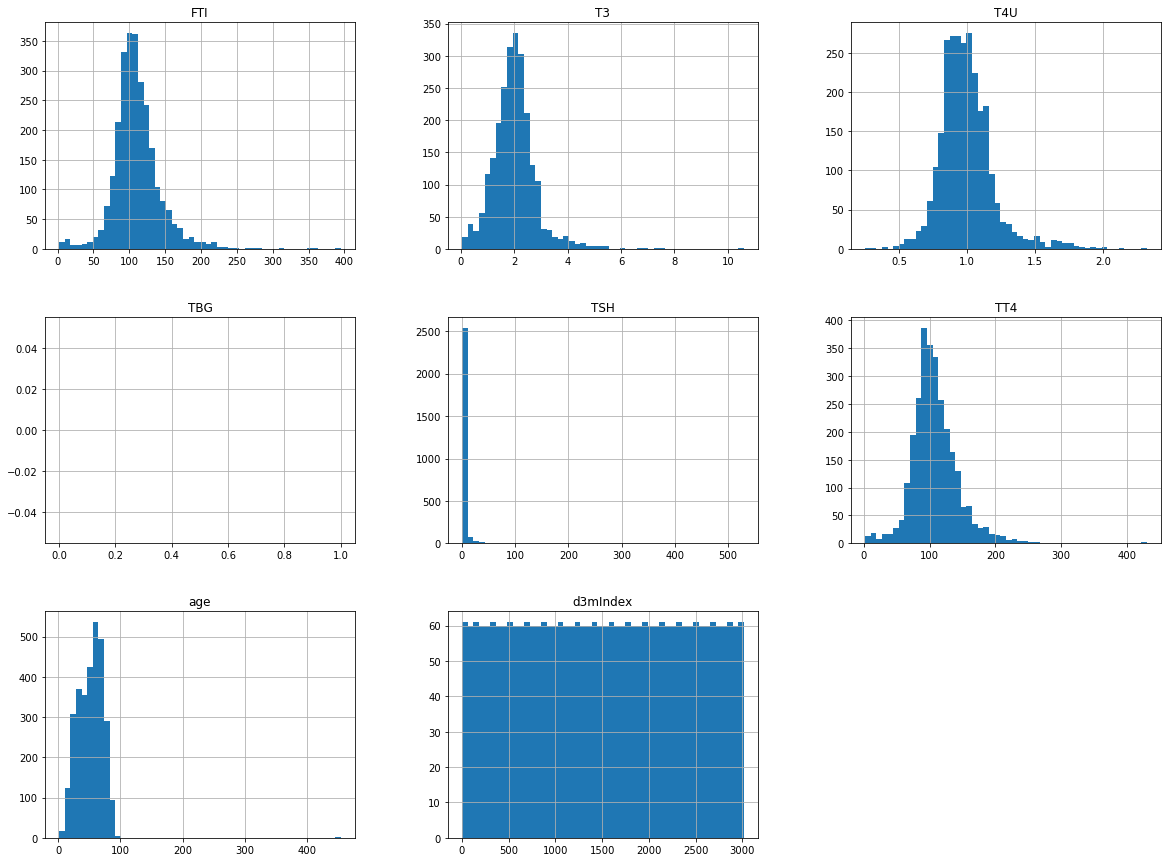

In [56]:
#Attempt to the problem by Dani
#Load training data set
data = pd.read_csv(DATADIR +'/trainData.csv')
labels = pd.read_csv(DATADIR +'/trainTargets.csv')
#data.head()
#data.describe()
#data.info() #useful to get information about the loaded data
#data["sex"].value_counts()#this is useful to know which type of categories we have in the document
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

In [167]:
#creation of training test and test set. The random seed is always the same to ensure that the test data remains unknown
#test_ratio = 0.2
#np.random.seed(42) #We set up the random seed so the random test set is always the same!
#shufled_indices = np.random.permutation(len(data)) 
#test_size = int(len(data)*test_ratio)
##test = shufled_indices[:test_size] #Should not look at these data until we validate
#training = shufled_indices[test_size:]
#len(test)
#training = data.iloc[training]#iloc is selection by position. Basically, you pass the position indices and retrieves the vector
#training.head()

#Using sklearn primitives to do the split train test
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)
trainLabels, testLabels = train_test_split(labels, test_size=0.2, random_state=42)
# The 42 is to ensure that we get all the time the same test set. It could be any number.
# The problem with this sampling method is that if the dataset is not distributed equally (as it happens here), we could
# introduce bias. We should oversample the negative instances.
# This can be avoided with the StratifiedShuffleSplit primitive -> divides the

#add the target labels to the training (this will make things easier after we clean the data)
#train.loc[:,'target']= trainLabels["Class"]
#df1 = df1.assign(e=p.Series(np.random.randn(sLength)).values)
train = train.assign(target=trainLabels["Class"])
test = test.assign(target=testLabels["Class"])
train.head()
#trainLabels.info()
#train["referral_source"].value_counts()

,d3mIndex,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,...,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target
1377,1377,29.0,F,t,f,f,f,f,f,f,...,t,95.0,t,0.90,t,106.0,f,NaN,other,negative
96,96,43.0,M,f,f,f,f,f,f,f,...,t,98.0,t,0.89,t,110.0,f,NaN,SVHC,negative
1373,1373,37.0,F,f,f,f,f,f,f,f,...,t,84.0,t,1.24,t,68.0,f,NaN,STMW,negative
2585,2585,73.0,F,f,f,f,f,f,f,f,...,t,70.0,t,0.93,t,75.0,f,NaN,SVI,negative
2881,2881,67.0,F,f,f,f,f,f,f,f,...,t,104.0,f,NaN,f,NaN,f,NaN,SVI,negative


In [171]:
#remove the d3mIndex column from the training data (not useful)
trainClean = train.drop("d3mIndex", axis=1)
testClean = test.drop("d3mIndex", axis=1)
#trainClean["TBG"].value_counts() # is empty TBG 
trainClean = trainClean.drop("TBG", axis=1)
testClean = testClean.drop("TBG", axis=1)
#len(trainClean)
trainClean = trainClean.dropna()
testClean = testClean.dropna()
#Removes all rows with missing values. Note that this implies removing 500 rows... Is this part of the data cleaning?
trainClean.head()



,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,referral_source,target
1377,29.0,F,t,f,f,f,f,f,f,f,...,1.5,t,95.0,t,0.90,t,106.0,f,other,negative
96,43.0,M,f,f,f,f,f,f,f,f,...,1.9,t,98.0,t,0.89,t,110.0,f,SVHC,negative
1373,37.0,F,f,f,f,f,f,f,f,f,...,2.4,t,84.0,t,1.24,t,68.0,f,STMW,negative
2585,73.0,F,f,f,f,f,f,f,f,f,...,1.3,t,70.0,t,0.93,t,75.0,f,SVI,negative
1255,53.0,M,f,f,f,f,f,f,f,f,...,1.2,t,105.0,t,0.91,t,115.0,f,SVHC,negative


In [185]:
# declare multi column encoder
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = preprocessing.LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = preprocessing.LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)
    
trainBinarized = MultiColumnLabelEncoder(columns = ['sex','on_thyroxine','query_on_thyroxine','on_antithyroid_medication',
    'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment','query_hypothyroid','query_hyperthyroid',
     'lithium','goitre','tumor','hypopituitary','psych','TSH_measured','T3_measured',
    'TT4_measured','T4U_measured','FTI_measured','TBG_measured','referral_source', 'target']).fit_transform(trainClean)

testBinarized = MultiColumnLabelEncoder(columns = ['sex','on_thyroxine','query_on_thyroxine','on_antithyroid_medication',
    'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment','query_hypothyroid','query_hyperthyroid',
     'lithium','goitre','tumor','hypopituitary','psych','TSH_measured','T3_measured',
    'TT4_measured','T4U_measured','FTI_measured','TBG_measured','referral_source', 'target']).fit_transform(testClean)

#Label binarizer does binarization + one hot, but only column per column
#encoder = preprocessing.LabelBinarizer()
#trainCleanHot = encoder.fit_transform(trainClean["sex"])#translated to 1 category: you either have it or not.
trainBinarizedNoTarget = trainBinarized.drop("target",axis=1)
testBinarizedNoTarget = testBinarized.drop("target",axis=1)
targetBinarized = trainBinarized["target"]
testTargetBinarized = testBinarized["target"]
trainBinarizedNoTarget.head()
#targetBinarized

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,referral_source
1377,29.0,0,1,0,0,0,0,0,0,0,...,0,1.5,0,95.0,0,0.90,0,106.0,0,4
96,43.0,1,0,0,0,0,0,0,0,0,...,0,1.9,0,98.0,0,0.89,0,110.0,0,1
1373,37.0,0,0,0,0,0,0,0,0,0,...,0,2.4,0,84.0,0,1.24,0,68.0,0,0
2585,73.0,0,0,0,0,0,0,0,0,0,...,0,1.3,0,70.0,0,0.93,0,75.0,0,3
1255,53.0,1,0,0,0,0,0,0,0,0,...,0,1.2,0,105.0,0,0.91,0,115.0,0,1


In [174]:
#Now that we have binarized, we have to do the one_hot
trainCleanHot = preprocessing.OneHotEncoder(categorical_features=[27],
    sparse=False, handle_unknown='ignore').fit_transform(trainBinarizedNoTarget)
#0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,20,22,24,26,
# I have only applied one hot to the last category because the rest were already binary!
#len(trainCleanHot)
testCleanHot = preprocessing.OneHotEncoder(categorical_features=[27],
    sparse=False, handle_unknown='ignore').fit_transform(testBinarizedNoTarget)
trainCleanHot[0]#Now the vector has 32 columns: only 4 new categories added (last attribute).

array([   0. ,    0. ,    0. ,    0. ,    1. ,   29. ,    0. ,    1. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,   14. ,    0. ,
          1.5,    0. ,   95. ,    0. ,    0.9,    0. ,  106. ,    0. ])

In [196]:
#Model training
clf = svm.SVC()
from sklearn.metrics import accuracy_score
#get those labels for the columns that I have in the training data
clf.fit(trainCleanHot, targetBinarized)
y_pred = clf.predict(testCleanHot)
#testTargetBinarized
#targetBinarized
print(accuracy_score(testTargetBinarized, y_pred))

#tests on the non hot set
clf.fit(trainBinarizedNoTarget, targetBinarized)
y_pred = clf.predict(testBinarizedNoTarget)
accuracy_score(testTargetBinarized, y_pred)

0.905797101449


0.90579710144927539

In [51]:
#Below is the attempt by Varun
# Load the data schema json
#data_schema = DATADIR + '/dataSchema.json'
#with open(data_schema) as json_file:
#    schema = json.load(json_file)
#schema
#ttle = preprocessing.LabelEncoder()
#trainTargets = pd.read_csv(DATADIR + '/trainTargets.csv', index_col='d3mIndex')
#trainTargetsSeries = trainTargets['Class'].values
#ttnumeric = ttle.fit_transform(trainTargetsSeries)
#ttnumeric
#tdle = preprocessing.OneHotEncoder(categorical_features=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,20,22,24,26,28],
#    sparse=False, handle_unknown='ignore')
#trainData = pd.read_csv(DATADIR + '/trainData.csv', index_col='d3mIndex').as_matrix()
#tdnumeric = tdle.fit_transform(trainData)
#pprint(tdnumeric)
#clf = svm.SVC()
#clf.fit(tdnumeric, ttnumeric)

#testData = pd.read_csv(DATADIR + '/testData.csv')
#results = clf.predict(testData)

#results